# Project 2: Getting Proficient!
------------------------------------------------

The purpose of this project is to master the topics of:
* blending Python and SQL
* using pandas UDFs
* writing window functions

Some of the earlier questions will be relatively straight-foward, but the last question or two will have many different approaches available. Make sure to check your work and show that your approach actually did what you wanted it to do!

# Install Spark

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=1fb4e95b5f3b334ae6bd4c7cb1f36cc251d39a960caf89f6a3ead0caae4f53e3
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


## Start a Spark Session

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .appName("Project2")\
        .getOrCreate()

In [3]:
# some useful functions
import pyspark.sql.functions as F
import pyspark.sql.types as T

# Read the Data
We will use the GSOD dataset from Chapter 10.

In [5]:
# mount your Drive and update your Path
import os
os.getcwd()
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
myDir = '/content/drive/MyDrive/Cloud_Computing/Material/'
gsod1 = spark.read.parquet(myDir + 'gsod1.parquet')
gsod2 = spark.read.parquet(myDir + 'gsod2.parquet')
gsod3 = spark.read.parquet(myDir + 'gsod3.parquet')
gsod4 = spark.read.parquet(myDir + 'gsod4.parquet')

In [7]:
gsod = (
 gsod1.select(gsod4.columns)
 .union(gsod2.select(gsod4.columns))
 .union(gsod3.select(gsod4.columns))
 .union(gsod4)
)

In [8]:
# rows and columns
# 12M rows and 32 columns
print(gsod.count(), len(gsod.columns))

12460217 32


In [9]:
# schema
gsod.printSchema()

root
 |-- stn: string (nullable = true)
 |-- wban: string (nullable = true)
 |-- year: string (nullable = true)
 |-- mo: string (nullable = true)
 |-- da: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- count_temp: long (nullable = true)
 |-- dewp: double (nullable = true)
 |-- count_dewp: long (nullable = true)
 |-- slp: double (nullable = true)
 |-- count_slp: long (nullable = true)
 |-- stp: double (nullable = true)
 |-- count_stp: long (nullable = true)
 |-- visib: double (nullable = true)
 |-- count_visib: long (nullable = true)
 |-- wdsp: string (nullable = true)
 |-- count_wdsp: string (nullable = true)
 |-- mxpsd: string (nullable = true)
 |-- gust: double (nullable = true)
 |-- max: double (nullable = true)
 |-- flag_max: string (nullable = true)
 |-- min: double (nullable = true)
 |-- flag_min: string (nullable = true)
 |-- prcp: double (nullable = true)
 |-- flag_prcp: string (nullable = true)
 |-- sndp: double (nullable = true)
 |-- fog: string (nullable =

In [10]:
# look at the first few rows
gsod.show(10, truncate=False)

+------+-----+----+---+---+----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+
|stn   |wban |year|mo |da |temp|count_temp|dewp  |count_dewp|slp   |count_slp|stp   |count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd|gust |max |flag_max|min |flag_min|prcp|flag_prcp|sndp |fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|
+------+-----+----+---+---+----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+
|998258|99999|2017|03 |08 |32.9|11        |9999.9|0         |1009.2|11       |9999.9|0        |999.9|0          |5.6 |11        |13.0 |999.9|35.6|*       |30.7|*       |0.0 |I        |999.9|0  |0           |0               

# 🔵 (30 pts, 5 pts each) Blending Python and SQL

In [11]:
# gsod is the dataframe , read as table for sql
gsod.createOrReplaceTempView("gsod_table")

### Select all rows where `temp` is greater than 90 and where windspeed is greater than 20.

In [12]:
spark.sql(
 "select * from gsod_table where (temp > 90 AND wdsp > 20)"
).show(10, False)

+------+-----+----+---+---+-----+----------+------+----------+------+---------+------+---------+-----+-----------+-----+----------+-----+-----+-----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+
|stn   |wban |year|mo |da |temp |count_temp|dewp  |count_dewp|slp   |count_slp|stp   |count_stp|visib|count_visib|wdsp |count_wdsp|mxpsd|gust |max  |flag_max|min |flag_min|prcp|flag_prcp|sndp |fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|
+------+-----+----+---+---+-----+----------+------+----------+------+---------+------+---------+-----+-----------+-----+----------+-----+-----+-----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+
|999999|53139|2017|05 |29 |95.4 |24        |9999.9|0         |9999.9|0        |9999.9|0        |999.9|0          |999.9|0         |999.9|999.9|109.4|        |79.2|        |0.0 |G        |999.9|0  |0           |0   

### Print the count of rows and show first 10 rows to confirm your answer.

In [13]:
# count the total number of rows satisfying the condition
spark.sql(
 "select count(*) from gsod_table where (temp > 90 AND wdsp > 20)"
).show(10)

+--------+
|count(1)|
+--------+
|    3741|
+--------+



In [14]:
# display 10 rows satisfying the above condition
spark.sql(
 "select * from gsod_table where (temp > 90 AND wdsp > 20)"
).show(10)

+------+-----+----+---+---+-----+----------+------+----------+------+---------+------+---------+-----+-----------+-----+----------+-----+-----+-----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+
|   stn| wban|year| mo| da| temp|count_temp|  dewp|count_dewp|   slp|count_slp|   stp|count_stp|visib|count_visib| wdsp|count_wdsp|mxpsd| gust|  max|flag_max| min|flag_min|prcp|flag_prcp| sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|
+------+-----+----+---+---+-----+----------+------+----------+------+---------+------+---------+-----+-----------+-----+----------+-----+-----+-----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+
|999999|53139|2017| 05| 29| 95.4|        24|9999.9|         0|9999.9|        0|9999.9|        0|999.9|          0|999.9|         0|999.9|999.9|109.4|        |79.2|        | 0.0|        G|999.9|  0|           0|    

### How many unique stations met the condition of temp>90 and wdsp>20?

In [15]:
spark.sql(
 "select COUNT(DISTINCT stn) from gsod_table where (temp > 90 AND wdsp > 20)"
).show()

+-------------------+
|count(DISTINCT stn)|
+-------------------+
|                283|
+-------------------+



### Find the top 10 stations (`stn`) where the condition is true.

CHECK IF RANK NEEDED?

In [16]:
from pyspark.sql.window import Window

windowSpec = Window.partitionBy("stn").orderBy(F.desc("wdsp"), F.desc("temp"))

In [17]:
# filter for rows where temp > 90 and wdsp > 20
filtered_df = gsod.filter((F.col('temp') > 90) & (F.col('wdsp') > 20))

# calculate rank within each stn partition
ranked_df = filtered_df.withColumn('rank', F.rank().over(windowSpec))

# calculate average rank by stn
result_df = ranked_df.select('stn', 'rank').groupBy('stn').agg(F.avg('rank').alias('rank')).orderBy('rank')

# display result
result_df.show(10)

+------+----+
|   stn|rank|
+------+----+
|368700| 1.0|
|403600| 1.0|
|377870| 1.0|
|355220| 1.0|
|381110| 1.0|
|162600| 1.0|
|382021| 1.0|
|368210| 1.0|
|382620| 1.0|
|368060| 1.0|
+------+----+
only showing top 10 rows



### Where is the top station (that is not 999999)?
Below is the list of all GSOD stations - Google the location and let me know where it is by writing your answer and embedding a picture!

Here is a list of all the GSOD stations:
* http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.GSOD/.MONTHLY/.Name/IWMO+exch+table-+text+text+skipanyNaN+-table+.html

**Answer:** ABC is STATION XYZ - it is hot and windy there!

(embed a picture here from Google Images or Wikipedia)

Answer: Top stations is 368700.
As found from the above query, the top station thta is not 999999 is 406220 and its location is Almaty.

Almaty, Kazakhstan's largest metropolis, is set in the foothills of the Trans-Ili Alatau mountains.

It is hot and sunny there.


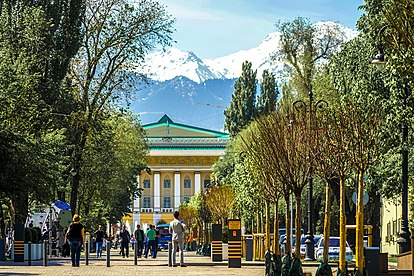

### What month/year was the hottest and windiest at that particular station?

In [18]:
window_Spec = Window.partitionBy("temp, wdsp").orderBy(F.desc("wdsp"), F.desc("temp"))

In [19]:
# filter for rows where temp > 90, wdsp > 20, and stn = 368700
filtered_df = gsod.filter((F.col('temp') > 90) & (F.col('wdsp') > 20) & (F.col('stn') == 368700))

# calculate rank within each stn partition
ranked_df = filtered_df.withColumn('rank', F.rank().over(windowSpec))

# order by rank and select the first row
result_df = ranked_df.orderBy('rank').select('mo', 'year').limit(1)

# display result
result_df.show()

+---+----+
| mo|year|
+---+----+
| 07|2017|
+---+----+



# 🔵 (30 pts total, 10 pts each) Pandas UDFs

## Return summary statistics of the `temp` and `wdsp` columns and note the range of values.

Please show the count, min 25th, 50th, 75th percentile and max value.

In [20]:
gsod.select(F.col('temp'), F.col('wdsp')).summary("count","min","25%","50%","75%","max").show()

+-------+--------+--------+
|summary|    temp|    wdsp|
+-------+--------+--------+
|  count|12460217|12460217|
|    min|  -114.7|     0.0|
|    25%|    41.2|     3.5|
|    50%|    58.5|     5.6|
|    75%|    73.7|     8.7|
|    max|   110.0|   999.9|
+-------+--------+--------+



It looks like there are some missing values for the wdsp column.

Review this metadata for the units of each column:
* https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt

```
TEMP - Mean temperature (.1 Fahrenheit)
DEWP - Mean dew point (.1 Fahrenheit)
SLP - Mean sea level pressure (.1 mb)
STP - Mean station pressure (.1 mb)
VISIB - Mean visibility (.1 miles)
WDSP – Mean wind speed (.1 knots)
MXSPD - Maximum sustained wind speed (.1 knots)
GUST - Maximum wind gust (.1 knots)
MAX - Maximum temperature (.1 Fahrenheit)
MIN - Minimum temperature (.1 Fahrenheit)
PRCP - Precipitation amount (.01 inches)
SNDP - Snow depth (.1 inches)
```



## Write a Pandas UDF that converts temperature from F to C


In [21]:
import pandas as pd
@F.pandas_udf(T.DoubleType()) # this is the datatype of the output... a float
def f_to_c(degrees: pd.Series) -> pd.Series: # it takes a series and ouptus a series
 """Transforms Farhenheit to Celcius."""
 return ((degrees - 32) * (5 / 9))

Now add it as a column in `gsod`.

In [22]:
gsod = gsod.withColumn("temp_c", f_to_c(F.col("temp")))

In [23]:
gsod.show(10, truncate=False)

+------+-----+----+---+---+----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+------------------+
|stn   |wban |year|mo |da |temp|count_temp|dewp  |count_dewp|slp   |count_slp|stp   |count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd|gust |max |flag_max|min |flag_min|prcp|flag_prcp|sndp |fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|temp_c            |
+------+-----+----+---+---+----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+------------------+
|998258|99999|2017|03 |08 |32.9|11        |9999.9|0         |1009.2|11       |9999.9|0        |999.9|0          |5.6 |11        |13.0 |999.9|35.6|*       |30.7|*     

## Write a Pandas UDF that converts `WDSP` from knots to m/s

In [24]:
# replace a specific value with 0 in the column "wdsp"
gsod = gsod.withColumn("wdsp", F.regexp_replace(F.col("wdsp"), "999", "0"))

# convert the "cwdsp" column to a double data type
gsod = gsod.withColumn("wdsp", F.col("wdsp").cast(T.DoubleType()))

In [25]:
import pandas as pd

@F.pandas_udf(T.DoubleType())
def k_to_ms(wdsp: pd.Series) -> pd.Series:
 return wdsp * 0.514444

In [26]:
gsod = gsod.withColumn("wdsp_ms", k_to_ms(F.col("wdsp")))

In [27]:
gsod.show()

+------+-----+----+---+---+-----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+-----+--------+------+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+------------------+------------------+
|   stn| wban|year| mo| da| temp|count_temp|  dewp|count_dewp|   slp|count_slp|   stp|count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd| gust|  max|flag_max|   min|flag_min|prcp|flag_prcp| sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|            temp_c|           wdsp_ms|
+------+-----+----+---+---+-----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+-----+--------+------+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+------------------+------------------+
|998258|99999|2017| 03| 08| 32.9|        11|9999.9|         0|1009.2|       11|9999.9|        0|9

# 🔵 (20 pts total, 10 pts each) Window Functions

## Station Quality

In [28]:
# these are the total number of stations - 12k
print('These are the counts of all stations:', gsod.select('stn').distinct().count())
# look at stations with sparse data quality - 9.9k
tmp = gsod.groupby('stn').count().orderBy('count')
# let's keep stations that have 300*3 = 900 observations
tmp = tmp.where(f'count > 900').select('stn', 'count')
print('These are the counts of stations with decent data quality:', tmp.distinct().count())
tmp.show()

These are the counts of all stations: 12832
These are the counts of stations with decent data quality: 9963
+------+-----+
|   stn|count|
+------+-----+
|760400|  901|
|627900|  901|
|943930|  902|
|718433|  902|
|368710|  903|
|014650|  903|
|817520|  903|
|717360|  903|
|817880|  904|
|719043|  904|
|423720|  904|
|724856|  905|
|703333|  905|
|618560|  905|
|268500|  905|
|272230|  905|
|722363|  905|
|368830|  905|
|160360|  905|
|655600|  906|
+------+-----+
only showing top 20 rows



In [29]:
# make a plot of those stations with good data quality
import matplotlib.pyplot as plt
import pandas as pd

tmp = tmp.toPandas()
tmp.describe()

,count
count,9963.000000
mean,1105.040149
std,3123.529808
min,901.000000
25%,1076.000000
50%,1085.000000
75%,1086.000000
max,312826.000000


In [30]:
# the top stn was 99999 which is missing values, so making a plot for postion 1 and onwards
tmp = tmp.sort_values('count', ascending=False).iloc[1:].head(21)

In [31]:
tmp1 = tmp.head(20)
tmp1

,stn,count
9961,720613,1257
9960,720609,1252
9959,747918,1243
9958,720408,1243
9957,720586,1242
9956,720738,1240
9955,720254,1238
9954,720643,1238
9953,720961,1236
9951,720448,1235


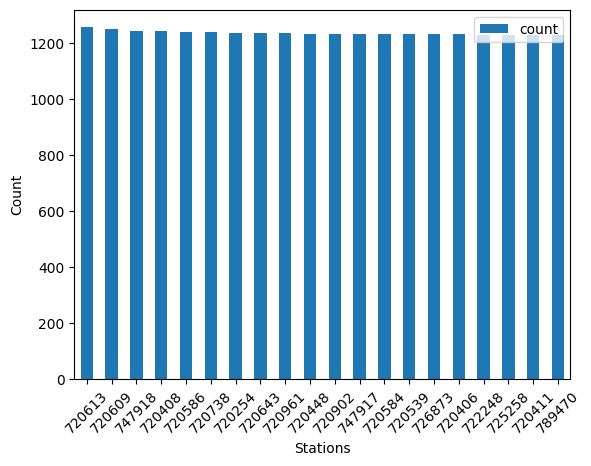

In [32]:
# bar plot for tmp1
tmp1.plot.bar('stn','count')
plt.xlabel("Stations")
plt.ylabel("Count")
plt.xticks(rotation = 45)
plt.show()

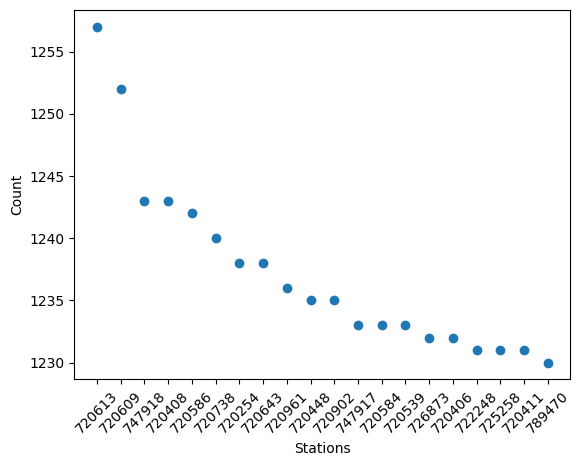

In [33]:
#scatter plot for tmp1
plt.scatter(tmp1['stn'], tmp1['count'])
plt.xlabel("Stations")
plt.ylabel("Count")
plt.xticks(rotation = 45)
plt.show()

## Rolling Averages

Read this:
* https://stackoverflow.com/questions/45806194/pyspark-rolling-average-using-timeseries-data

...decide which answer is closest to our GSOD dataset, and decide if you need to use rowBetween and rangeBetween! Remember your data is in daily data right now and that you may not have a perfect of observations each day.

In [34]:
# getting the date and seconds column
gsod = (
    gsod.withColumn(
        "dt",
        F.to_date(F.concat_ws("-", F.col("year"), F.col("mo"), F.col("da"))),
    )
    .withColumn("dt_num", F.unix_timestamp("dt"))
)

In [35]:
gsod.show(10, False)

+------+-----+----+---+---+----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+------------------+------------------+----------+----------+
|stn   |wban |year|mo |da |temp|count_temp|dewp  |count_dewp|slp   |count_slp|stp   |count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd|gust |max |flag_max|min |flag_min|prcp|flag_prcp|sndp |fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|temp_c            |wdsp_ms           |dt        |dt_num    |
+------+-----+----+---+---+----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+------------------+------------------+----------+----------+
|998258|99999|2017|03 |08 |32.9|11        |

Now select one station for demonstation purposes - let's just use `stn == 406370` for demo purposes.

In [36]:
unixTimestamp = gsod.where(F.col('stn')== '406370')

In [37]:
print(unixTimestamp.count(), len(unixTimestamp.columns))

887 36


Convert this data sample toPandas() and make a nice line plot of `temp` vs. date. Remember to convert the date to a datetime and then set the index as the date column in order to get a nice looking graph.

In [38]:
# converting the dataframe to pandas
unixTimestamp1 = unixTimestamp.toPandas()


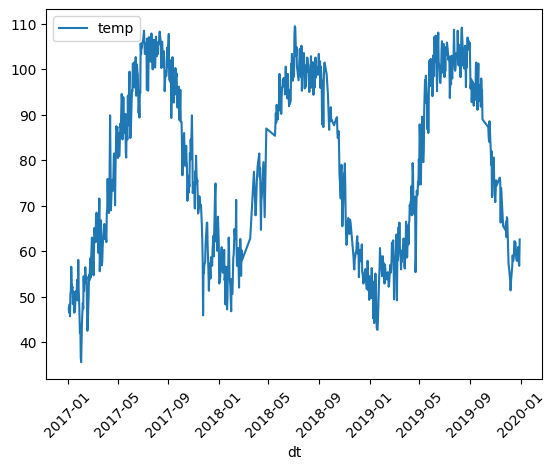

In [39]:
#plotting unixTimestamp
unixTimestamp1.plot(x="dt", y='temp', kind="line")
plt.xticks(rotation = 45)
plt.show()

Check to make sure there are no missing values in the `temp` column.

In [40]:
(unixTimestamp1['temp'].isnull().values.sum())

0

Check out the data quality of April 2018 and show 30 rows for this station. Make a comment about the data quality.

In [41]:
april2018 = gsod.where((F.col('year')=='2018')& (F.col('mo')=='04'))

In [42]:
april2018.show(30, False)

+------+-----+----+---+---+----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+------+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+-------------------+------------------+----------+----------+
|stn   |wban |year|mo |da |temp|count_temp|dewp  |count_dewp|slp   |count_slp|stp   |count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd|gust |max |flag_max|min   |flag_min|prcp|flag_prcp|sndp |fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|temp_c             |wdsp_ms           |dt        |dt_num    |
+------+-----+----+---+---+----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+------+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+-------------------+------------------+----------+----------+
|917350|99999|2018|04 |21 |82.6|9 

In [43]:
print("total unique stations for 2018 april:", april2018.select('stn').distinct().count())
count_april2018 = april2018.select('stn').groupby('stn').count().orderBy('count', ascending=False)

total unique stations for 2018 april: 11757


In [44]:
count_april2018.show()

+------+-----+
|   stn|count|
+------+-----+
|999999| 6368|
|721042|   60|
|720854|   60|
|720605|   60|
|720643|   60|
|722369|   60|
|720625|   60|
|720637|   60|
|725294|   60|
|720577|   60|
|720415|   60|
|749171|   60|
|721045|   60|
|720631|   60|
|722368|   60|
|720636|   60|
|720578|   60|
|720607|   60|
|722231|   60|
|720927|   60|
+------+-----+
only showing top 20 rows



Here I can see that after ordering count_april2018 by count, the max number of observations that I have for april 2018 is 60, so after checking the percentage I can see that it is very low, hence, the data quality in our opinion is not good.

In [45]:
# number of stn that have 60 observations, except for 999999
(count_april2018.where(F.col('count') == '60').count())

121

In [46]:
# total number for rows
(april2018.select('stn').count())

344096

In [47]:
# percentage of rows that have 60 observations
((count_april2018.where(F.col('count') == '60').count())/(april2018.select('stn').count()))*100

0.03516460522644844

Create the window function for a 3 day rolling temperature (remember - time matters!) The window should be composed of today, yesterday, and two days ago.

In [48]:
from pyspark.sql.window import Window

one_day_sec = 60 * 60 * 24

one_day_before_and_after = (
 Window.partitionBy("dt")
 .orderBy("dt_num")
)

In [49]:
unixTimestamp = unixTimestamp.withColumn('dt', F.col('dt').cast('timestamp'))

In [50]:
#counting the seconds days
days = lambda i: i * 86400

In [51]:
window_spec = Window.orderBy(unixTimestamp.dt.cast('long')).rangeBetween(-days(3), 0)
rolling_temp = F.avg(unixTimestamp.temp).over(window_spec)

In [52]:
# making new column
unixTimestamp = unixTimestamp.withColumn("avg_rolling_temp", rolling_temp)

In [53]:
unixTimestamp.show(10, False)

+------+-----+----+---+---+----+----------+----+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+------------------+---------+-------------------+----------+------------------+
|stn   |wban |year|mo |da |temp|count_temp|dewp|count_dewp|slp   |count_slp|stp   |count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd|gust |max |flag_max|min |flag_min|prcp|flag_prcp|sndp |fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|temp_c            |wdsp_ms  |dt                 |dt_num    |avg_rolling_temp  |
+------+-----+----+---+---+----+----------+----+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+------------------+---------+-------------------+----------+------------

Make a line plot with the raw temperature value (in blue) and the rolling window temperature value (in orange).

In [54]:
unixTimestamp = unixTimestamp.toPandas()

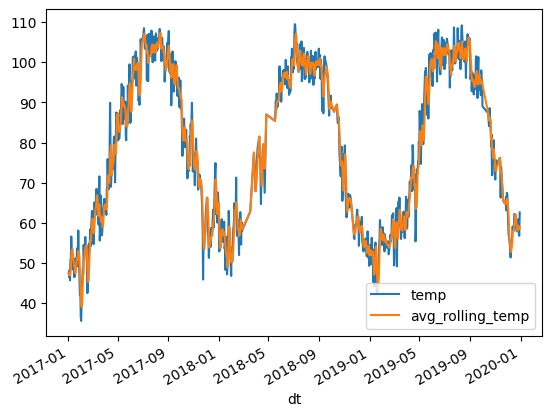

In [55]:
unixTimestamp.plot(x = 'dt', y = ['temp', 'avg_rolling_temp'])
plt.legend()
plt.show()

# 🔵 (20 pts total) Pandas UDFs and/or Window Functions

This is probably the hardest part of the project - spend some time on this and try a few different approaches if needed! I recommend just using a single station with all observations - how about station 406370?

## Consecutive Values Above Threshold
I would like a new column in the PySpark DataFrame that contains the maximum consecutive values above a threshold (>=90 degF).

If the raw values are [91, 89, 88, 93, 94, 101, 85], then the output should be [1, 0, 0, 1, 2, 3, 0]. You are summing cumulative logical values!

Now go code it up!

In [56]:
import numpy as np
import pandas as pd

# getting the data for station 406370
consec = gsod.where(F.col('stn') == '406370').select(F.col('*'))

In [57]:
# Creating a window partitioned by station and ordered by date
window_spec = Window.partitionBy('stn').orderBy('dt')

# Creating a new column 'above_threshold' which is 1 if temp >= 90 and 0 otherwise
consec = consec.withColumn('above_threshold', F.when(F.col('temp') >= 90, 1).otherwise(0))

In [58]:
# converting dataframe to pandas
consec = consec.toPandas()

In [59]:
# assigning a unique counter value to each consecutive sequence of identical values in the "temp" column
consec['counter'] = consec['temp'].diff().ne(0).cumsum()

In [60]:
# finding the minimum value of the above_threshold column for each group of consecutive values
consec.groupby('counter')['above_threshold'].min()

counter
1      1
2      1
3      0
4      1
5      0
      ..
880    1
881    0
882    0
883    0
884    0
Name: above_threshold, Length: 884, dtype: int32

In [61]:
# Calculate consecutive 1s
consec['consec_temp'] = consec.loc[consec['above_threshold'] == 1].groupby((consec['above_threshold'] != 1).cumsum()).cumcount() + 1
consec['consec_temp'] = consec['consec_temp'].where(consec['above_threshold'] == 1, '')
consec['consec_temp'] = consec['consec_temp'].replace('', '0')
consec['consec_temp'] = consec['consec_temp'].astype(int)
consec.head(60)

,stn,wban,year,mo,da,temp,count_temp,dewp,count_dewp,slp,...,hail,thunder,tornado_funnel_cloud,temp_c,wdsp_ms,dt,dt_num,above_threshold,counter,consec_temp
0,406370,99999,2017,07,06,103.4,4,9999.9,0,9999.9,...,0,0,0,39.666667,0.463000,2017-07-06,1499299200,1,1,1
1,406370,99999,2017,07,14,95.3,4,53.8,4,9999.9,...,0,0,0,35.166667,0.463000,2017-07-14,1499990400,1,2,2
2,406370,99999,2017,02,04,44.6,4,38.1,4,1028.5,...,0,0,0,7.000000,0.463000,2017-02-04,1486166400,0,3,0
3,406370,99999,2017,07,13,101.8,4,55.2,4,997.6,...,0,0,0,38.777778,0.463000,2017-07-13,1499904000,1,4,1
4,406370,99999,2017,02,27,60.3,4,43.6,4,1018.5,...,0,0,0,15.722222,0.463000,2017-02-27,1488153600,0,5,0
5,406370,99999,2017,07,25,100.0,4,53.0,4,997.3,...,0,0,0,37.777778,0.463000,2017-07-25,1500940800,1,6,1
6,406370,99999,2017,08,28,99.6,4,52.5,4,1000.6,...,0,0,0,37.555556,0.463000,2017-08-28,1503878400,1,7,2
7,406370,99999,2017,11,15,72.1,4,46.8,4,1015.6,...,0,0,0,22.277778,0.463000,2017-11-15,1510704000,0,8,0
8,406370,99999,2017,10,14,83.2,4,50.6,4,1010.8,...,0,0,0,28.444444,0.463000,2017-10-14,1507939200,0,9,0
9,406370,99999,2017,12,30,67.6,4,49.4,4,1019.7,...,0,0,0,19.777778,0.463000,2017-12-30,1514592000,0,10,0


Check your answer on May 2018 for Station 406370 visually! Plot your raw temperature on one graph (as you see below) and plot your cumulative sum above a threshold on another graph. Then visually compare to make sure you solved it correctly. You can use a Pandas UDF only (hint: look at Chapters 8 and 9) and/or you can cleverly combine it with a Window function.

**CHECK YOUR WORK!!!**

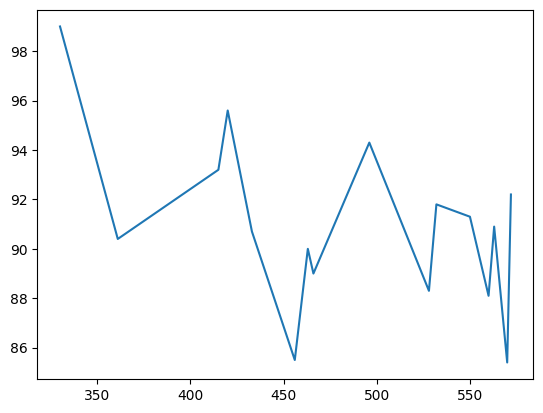

In [62]:
#plotting the raw temperature
gd = consec.loc[(consec['mo'] == '05') & (consec['year'] == '2018') & (consec['stn'] == '406370')]

gd['temp'].plot(x = 'dt', y = 'temp')
plt.show()

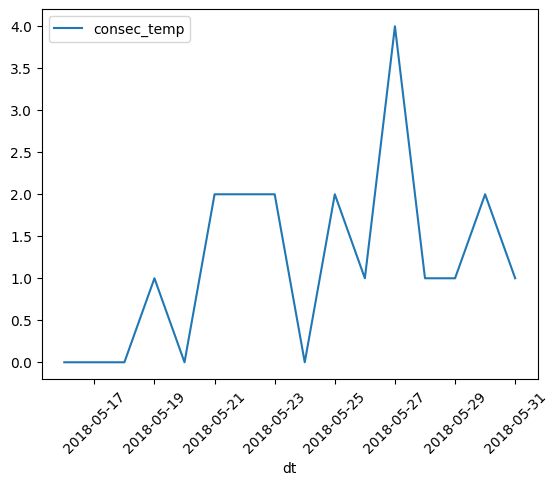

In [63]:
# plotting the consecutive temperature
gd.plot(x = 'dt', y = 'consec_temp')
plt.xticks(rotation = 45)
plt.show()

<ipython-input-64-85141c4edd8a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gd['dt'] = pd.to_datetime(gd['dt'])


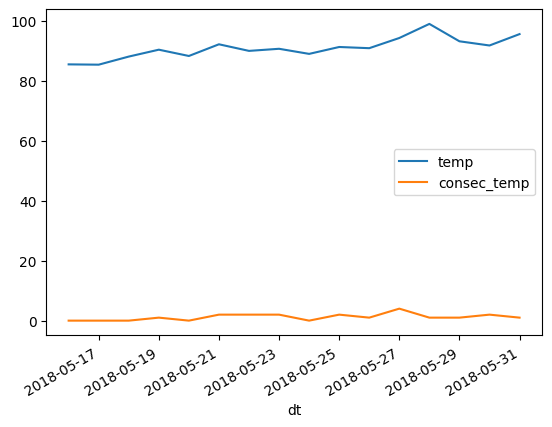

In [64]:
gd['dt'] = pd.to_datetime(gd['dt'])

gd.plot(x = 'dt', y = ['temp', 'consec_temp'])
plt.show()

No need to apply to all stations in GSOD if it takes too long - just use your sample from stn == 406370.